## RANSAC regression algorithm for differentiating outliers for a better model

### Load libraries and data

In [30]:
# importing relevant libraries
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import geopandas as gpd
%matplotlib inline

# Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.feature_selection import SequentialFeatureSelector

# Importing class balance tools for handling imbalanced datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from yellowbrick.target import ClassBalance

# Importing classifier models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Import plotyly
import plotly.express as px

# Import state abbreviations and FIPS
from state_names import state_abbreviations, state_to_fips

### Functions to test this data

In [31]:
# Robustly fit linear model with RANSAC algorithm
def ransac_linear(X_train, y_train, X_test, y_test, data_df=pd.DataFrame(), seed=None):
    ransac = RANSACRegressor(max_trials=500, min_samples=30000, loss='squared_error')

    if seed is not None:
        ransac = RANSACRegressor(random_state=seed, max_trials=500, min_samples=30000, loss='squared_error')
    
    ransac.fit(X_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_pred = ransac.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred)
    r2_train = ransac.score(X_train, y_train)

    # print(f"Mean Squared Error Train: {mse_train}")
    # print(f"R-squared Train: {r2_train}")

    y_pred = ransac.predict(X_test)

    # Evaluating the model
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = ransac.score(X_test, y_test)

    # print(f"Mean Squared Error Test: {mse_test}")
    # print(f"R-squared Test: {r2_test}")
    outlier_count = -1
    if not data_df.empty:
        outlier_mask = np.logical_not(ransac.inlier_mask_)
        data_df['Is_Outlier'] = outlier_mask
        outlier_count = data_df[data_df['Is_Outlier'] == True].shape[0]

    return mse_train, mse_test, r2_train, r2_test, data_df, outlier_count, ransac.estimator_.coef_

def run_several_ransac_linear(n_to_run, X_train, y_train, X_test, y_test, data_df=pd.DataFrame()):
    mse_trains = []
    mse_tests = []
    r2_trains = []
    r2_tests = []
    outlier_count = []
    for x in range(n_to_run):
        results = ransac_linear(X_train, y_train, X_test, y_test, data_df, x)
        mse_trains.append(results[0])
        mse_tests.append(results[1])
        r2_trains.append(results[2])
        r2_tests.append(results[3])
        outlier_count.append(results[5])


    print(r2_tests)
    print(outlier_count)
    print("")
    print("Mean MSE Train: ", sum(mse_trains)/len(mse_trains))
    print("Mean R2 Train: ", sum(r2_trains)/len(r2_trains))
    print("Mean MSE Test: ", sum(mse_tests)/len(mse_tests))
    print("Mean R2 Test: ", sum(r2_tests)/len(r2_tests))

### Load Data

In [32]:
data = pd.read_csv("all_data.csv", index_col=0)
data.drop(columns=['Date'], inplace=True)
data.rename(columns={'Value': 'Average Temperature Value'}, inplace=True)
data['StateFPS'] = data['StateAbbrv'].map(state_to_fips)
print(data.shape)
data.head()

(596366, 18)


,Year,Month,RegionName,State,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS
0,2000,1,Los Angeles County,CA,122826.545,400192.739,52.300,4.500,47.800,CA,0.930,8.010,15,103.000,173.600,64.700,7.000,06
1,2000,1,Los Angeles County,CA,122826.545,400192.739,52.300,4.500,47.800,CA,0.810,8.200,30,129.900,166.800,81.100,61.100,06
2,2000,1,Cook County,IL,71689.188,302264.545,24.900,2.400,22.500,IL,0.930,8.010,15,103.000,173.600,64.700,7.000,17
3,2000,1,Cook County,IL,71689.188,302264.545,24.900,2.400,22.500,IL,0.810,8.200,30,129.900,166.800,81.100,61.100,17
4,2000,1,Harris County,TX,61195.176,217850.463,57.400,5.600,51.800,TX,0.930,8.010,15,103.000,173.600,64.700,7.000,48


In [34]:
def scale_data(data):
    columns_to_scale = data.drop(columns=['Year', 'Month', 'RegionName', 'State', 'StateFPS', 'StateAbbrv']).columns

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the specified columns
    scaler.fit(data[columns_to_scale])

    # Transform the data using the fitted scaler and convert it back to a DataFrame
    scaled_data = scaler.transform(data[columns_to_scale])
    scaled_data_df = pd.DataFrame(scaled_data, columns=columns_to_scale, index=data.index)
    scaled_data_df['Year'] = data['Year']
    scaled_data_df['Month'] = data['Month']
    scaled_data_df['RegionName'] = data['RegionName']
    scaled_data_df['State'] = data['State']
    scaled_data_df['StateFPS'] = data['StateFPS']
    scaled_data_df['StateAbbrv'] = data['StateAbbrv']

    return scaled_data_df

scaled_data_df = scale_data(data)
# Display the first few rows of the DataFrame to check the results
scaled_data_df.head()

,Bottom-Tier Average Home Value Estimate,Top-Tier Average Home Value Estimate,Average Temperature Value,Anomaly (1901-2000 base period),1901-2000 Mean,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Year,Month,RegionName,State,StateFPS,StateAbbrv
0,0.429,0.541,-0.200,0.919,-0.383,0.108,2.474,-1.000,-2.005,-2.348,-0.912,-1.041,2000,1,Los Angeles County,CA,06,CA
1,0.429,0.541,-0.200,0.919,-0.383,-0.221,2.628,1.000,-1.278,-2.533,1.004,0.813,2000,1,Los Angeles County,CA,06,CA
2,-0.359,0.076,-1.803,0.298,-1.866,0.108,2.474,-1.000,-2.005,-2.348,-0.912,-1.041,2000,1,Cook County,IL,17,IL
3,-0.359,0.076,-1.803,0.298,-1.866,-0.221,2.628,1.000,-1.278,-2.533,1.004,0.813,2000,1,Cook County,IL,17,IL
4,-0.520,-0.325,0.099,1.244,-0.148,0.108,2.474,-1.000,-2.005,-2.348,-0.912,-1.041,2000,1,Harris County,TX,48,TX


In [35]:
# Loading the shapefile in order to visualize clean data on the US map
def merge_dfs(us_counties, data):
    data = us_counties.merge(data, left_on=['NAMELSAD', 'STATEFP'], right_on=['RegionName', 'StateFPS'])
    return data

us_counties = gpd.read_file('tl_2022_us_county/tl_2022_us_county.shp')

merged_data = merge_dfs(us_counties, data)
merged_scaled_data_df = merge_dfs(us_counties, scaled_data_df)
merged_scaled_data_df.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),Year,Month,RegionName,State,StateFPS,StateAbbrv
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-2.005,-2.348,-0.912,-1.041,2000,1,Lancaster County,NE,31,NE
1,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.278,-2.533,1.004,0.813,2000,1,Lancaster County,NE,31,NE
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-2.073,-2.370,-1.099,-1.034,2000,2,Lancaster County,NE,31,NE
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-1.335,-2.617,1.016,0.728,2000,2,Lancaster County,NE,31,NE
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,-2.054,-2.259,-1.146,-1.034,2000,3,Lancaster County,NE,31,NE


### Split the data

In [36]:
def split_data(data):
    test = data[data['Year'] == 2019].copy()
    train = data[data['Year'] != 2019].copy()
    y_test = test['Purchase Price ($thou)'].copy()
    y_train = train['Purchase Price ($thou)'].copy()
    X_train = train.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                        'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                        'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
    X_test = test.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                        'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                        'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).copy()
    return X_train, y_train, X_test, y_test, train, test

X_train, y_train, X_test, y_test, train, test = split_data(merged_data)
scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test, scaled_train, scaled_test = split_data(merged_scaled_data_df)

Feature selection from my Linear Regression revealed these features should be dropped. Let's keep this handy to try.

In [37]:
train_scaled_selected = scaled_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

X_train_selected = X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
X_test_selected = X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

scaled_X_train_selected = scaled_X_train.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                         'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])
scaled_X_test_selected = scaled_X_test.drop(columns=['Month', 'Initial Fees and Charges (%)', 'Term to Maturity', 'INTPTLAT', 'AWATER', 'ALAND', \
                                       'Top-Tier Average Home Value Estimate', 'Bottom-Tier Average Home Value Estimate', 'INTPTLON'])

### Run the RANSAC model 

Raw Data

In [38]:
run_several_ransac_linear(3, X_train, y_train, X_test, y_test, train)

[0.6805898091539133, 0.6796702856218957, 0.6769478048859938]
[210830, 209871, 209045]

Mean MSE Train:  48.99533096447063
Mean R2 Train:  0.9624585506641411
Mean MSE Test:  31.743072817918957
Mean R2 Test:  0.6790692998872676


In [27]:
run_several_ransac_linear(3, scaled_X_train_selected, scaled_y_train, scaled_X_test_selected, \
    scaled_y_test, train_scaled_selected)

[0.7954034818639144, 0.7954034818639144, 0.7954034818639144]
[4557, 4557, 4557]

Mean MSE Train:  0.03952346112170712
Mean R2 Train:  0.958943739332629
Mean MSE Test:  0.014926839291876
Mean R2 Test:  0.7954034818639144


In [28]:
results = ransac_linear(scaled_X_train_selected, scaled_y_train, scaled_X_test_selected, \
    scaled_y_test, train_scaled_selected, 3)

In [29]:
selected_features_ransac_results = results[4]
outliers = selected_features_ransac_results[selected_features_ransac_results['Is_Outlier']]
outliers['Year'].unique()

array([2008, 2012], dtype=int64)

In [ ]:
mask = ~data['Year'].isin([2008, 2012])
data_no_2008 = data[mask]

In [ ]:
scaled_data_df_no_2008 = scale_data(data_no_2008)
merged_data = merge_dfs(us_counties, data_no_2008)
merged_scaled_data_df = merge_dfs(us_counties, scaled_data_df_no_2008)

In [13]:
results = ransac_linear(scaled_X_train_selected, scaled_y_train, scaled_X_test_selected, \
    scaled_y_test, train_scaled_selected, 3)

In [17]:
results[4].columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT',
       'geometry', 'Average Temperature Value',
       'Anomaly (1901-2000 base period)', '1901-2000 Mean',
       'Effective Rate (%)', 'Loan Amount ($thou)', 'Purchase Price ($thou)',
       'Loan-to-Price Ratio (%)', 'Share of Total Market (%)', 'Year',
       'RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Is_Outlier'],
      dtype='object')

In [16]:
coefs = results[6]
cols = data.drop(columns=['RegionName', 'State', 'StateFPS', 'StateAbbrv', 'Purchase Price ($thou)', \
                       'STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',\
                       'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT','geometry']).columns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
coefficients = pd.DataFrame(data=coefs, index=cols, columns=["Coefficients"])
coefficients

ValueError: Shape of passed values is (8, 1), indices imply (17, 1)

In [ ]:
outliers = results[4].copy()
outliers = outliers[outliers['Is_Outlier']]
outliers['Year']

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011,
       2013, 2014, 2015, 2016, 2017, 2018], dtype=int64)

In [ ]:
data_2018 = results[4].copy()
data_2018 = data_2018[data_2018['Year'] == 2016]
data_2018 = data_2018[data_2018['Month'] == 3]
data_2018['Is_Outlier'] = data_2018['Is_Outlier'].astype(dtype='int')
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.set_axis_off()
us_counties.geometry.boundary.plot(ax=ax, edgecolor='k', linewidth = 0.5)
data_2018.plot(column='Is_Outlier', ax=ax, cmap='coolwarm', legend=True)

NameError: name 'results' is not defined

In [ ]:
ransac_data = results[4].copy()
outlier_counties = ransac_data[ransac_data['Is_Outlier'] == True]
outlier_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,StateAbbrv,Initial Fees and Charges (%),Effective Rate (%),Term to Maturity,Loan Amount ($thou),Purchase Price ($thou),Loan-to-Price Ratio (%),Share of Total Market (%),StateFPS,Is_Outlier
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,NE,0.930,8.010,15,103.000,173.600,64.700,7.000,31,True
2,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,NE,0.910,8.180,15,100.500,172.800,63.100,7.200,31,True
4,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,NE,0.870,8.240,15,101.200,176.900,62.700,7.200,31,True
6,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,NE,0.730,8.330,15,95.800,175.800,60.100,6.900,31,True
8,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,None,...,NE,0.810,8.480,15,96.200,178.600,58.400,6.400,31,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517974,54,099,01550056,54099,Wayne,Wayne County,06,H1,G4020,None,...,WV,1.280,3.720,15,191.900,304.900,68.500,6.800,54,True
517976,54,099,01550056,54099,Wayne,Wayne County,06,H1,G4020,None,...,WV,1.140,3.820,15,195.900,318.200,67.500,7.100,54,True
517978,54,099,01550056,54099,Wayne,Wayne County,06,H1,G4020,None,...,WV,1.210,3.940,15,204.600,322.300,68.900,6.900,54,True
517988,54,099,01550056,54099,Wayne,Wayne County,06,H1,G4020,None,...,WV,1.300,4.390,15,191.800,315.200,64.800,6.100,54,True


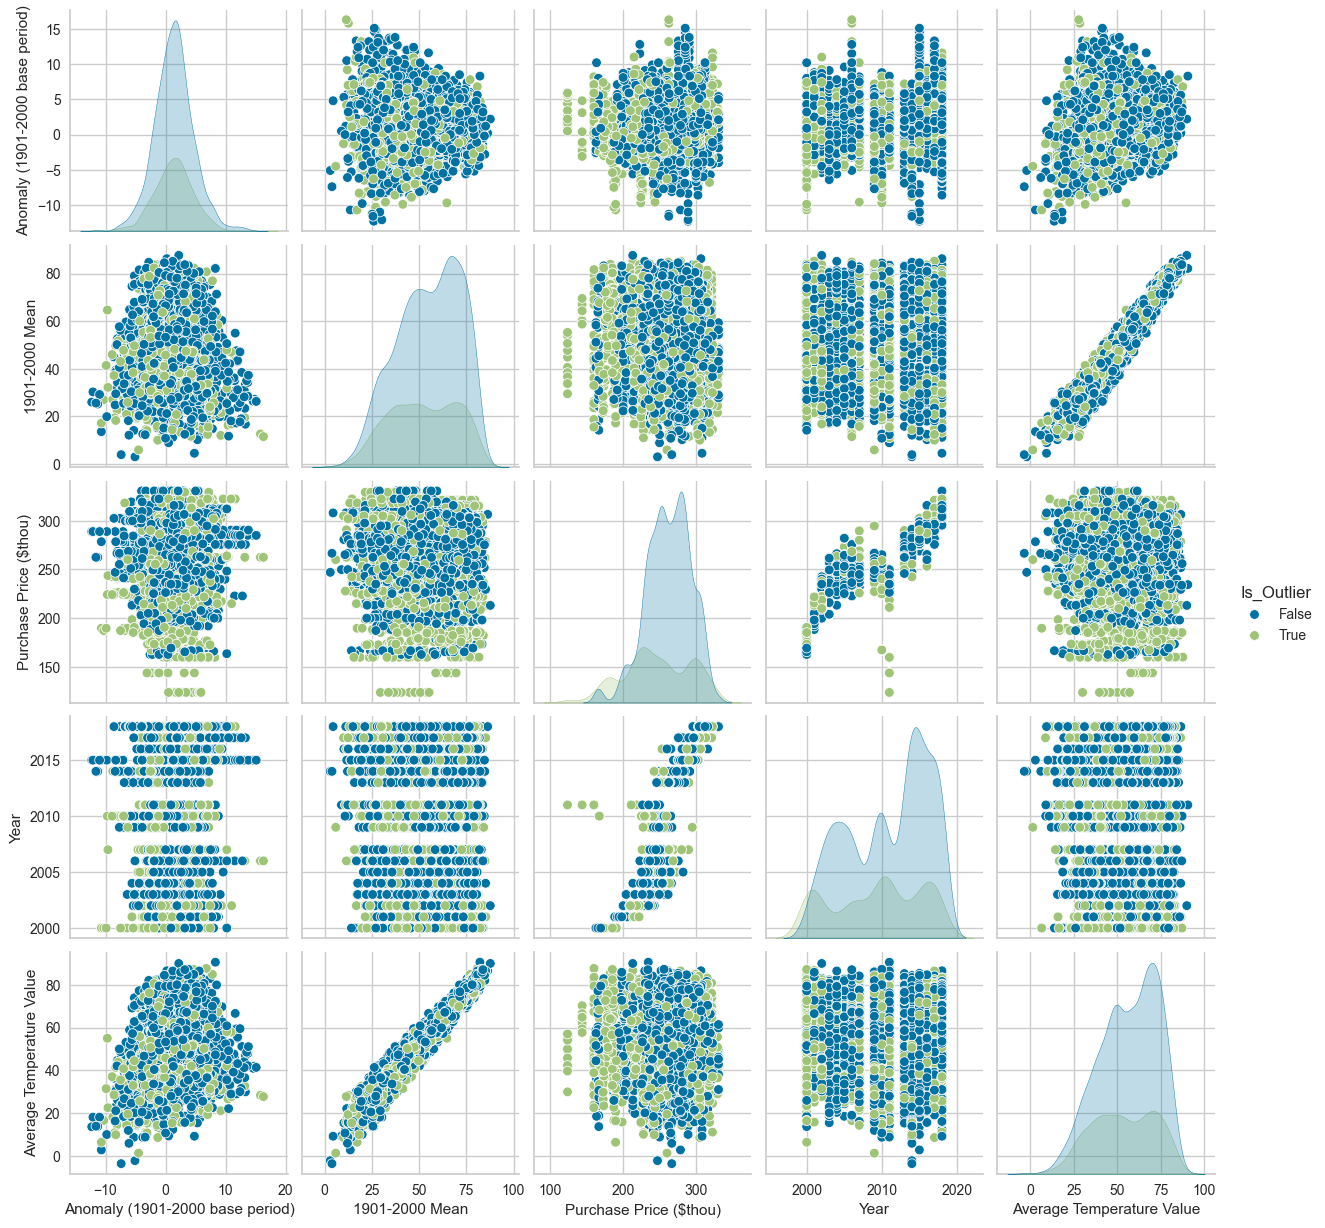

In [ ]:
s = ransac_data[['Anomaly (1901-2000 base period)', '1901-2000 Mean', 'Purchase Price ($thou)', 'Year', 'Average Temperature Value', 'Is_Outlier']].sample(5000)
sns.pairplot(data=s, hue='Is_Outlier')

In [ ]:
data = pd.read_csv("all_data.csv", index_col=0)
data['Is_Outlier'] = ransac_data['Is_Outlier']

In [ ]:
data.to_csv("all_data_w_outliers.csv")